# Starbucks Capstone Challenge

<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Problem Statement / Metrics


**The problem that I chose to solve is to build a model that predicts whether a customer will respond to an offer. My strategy for solving this problem has the following steps.** 

>1- clean and combine offer portfolio, customer profile, and transaction data. Each row of this combined dataset will describe an offer's attributes, customer demographic data, and whether the offer was successful. 

>2-  apply a different machine learning model and assess additional accuracy and F1-score. The 'naive model' assumes all offers were successful. This provides me with a baseline for evaluating the performance of models that I construct. Accuracy measures how well a model correctly predicts whether an offer is successful. 

>However, if the percentage of successful or unsuccessful offers is deficient, accuracy is not a good measure of model performance. For this situation, evaluating a model's precision and recall provides better insight into its account. Hence, I chose the F1-score metric because it is "a weighted average of the precision and recall metrics".

>3-, compare the performance of logistic regression, random forest, and gradient boosting models. And finally, refine the parameters of the model that has the highest accuracy and F1-score.**

### Project Components

***Therefore, with the above key statement in mind, below is the main objective or problem motivation or problem statement:***

**Build a model that predicts whether a customer would respond to an offer or not.**

>***The entire analysis would contain below steps:***

>1. Analyse each of the portfolio, profile and transaction data.
>2. Clean and tranform each of the portfolio, profile and transaction data.
>3. Combine portfolio, profile and transaction data.
>4. Select a performance metric to analyse performance of the model and to compare different models.
>5. Compute the performance of a baseline model against which performance of other different models would be compared.
>6. Select best performing model based on the metric and training time.
>7. Calculate the feature importances given by best estimator of the trained model.
>8. Compute the performance of best model on test set and visualize the performance via confusion matrix plot.


>>The resulting solution will be that best model would be able to determine which customers would respond.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import seaborn as sns
from pandas.core import datetools


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.svm import SVR

import statsmodels.api as sm

%matplotlib inline
plt.style.use('fivethirtyeight')

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


# 1. Analyse each of the portfolio, profile and transaction data

## 1.0 id dictionary

In [2]:
def id_mapper_dict():
    """
    In order to create a id dictionary
    1.  customer_id
    2.  offer_type_id
    3. merge all
    """
    # customer_id
    coded_dict = dict()
    cter = 1
    prefix = "C_"
    customer_encoded = []
    
    for val in profile['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        customer_encoded.append(coded_dict[val])
        
    id_dict = dict(zip(profile['id'], customer_encoded))
    
    # offer_type_id
    coded_dict = dict()
    cter = 1
    prefix = "F_"
    offer_encoded = []
    
    for val in portfolio['id']:
        if val not in coded_dict:
            coded_dict[val] = prefix + str(cter)
            cter+=1
        offer_encoded.append(coded_dict[val])
    offer_id_dict = dict(zip(portfolio['id'], offer_encoded))
    
    # merge dictionary
    id_dict.update(offer_id_dict)
    
    return id_dict
id_dict = id_mapper_dict()

## 1.1. Table of portfolio

### 1.1.1. Data Assess

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
# Print portfolio info
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [5]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


**Notes:**

>- id: offer_type id, the primary key of the table 
>- offer_type: there are 3 main and 10 sub offer types
>- difficulty: thredhold
>- reward: if accumulated consumptions over the threshold after received the offer and consuming during the valid date. 

## 1.1.2 Data Clean

- To convert offer_type to unique type like (offer_type)\_difficulty_duration_reward
- extract channels

In [7]:
portfolio['id'] = portfolio['id'].map(id_dict)

In [8]:
for element in ["web", "email", "mobile", "social"]:
    portfolio[element] = portfolio['channels'].apply(lambda x: 1 if element in x else 0)
portfolio.drop('channels', axis=1, inplace=True)

In [9]:
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,F_1,bogo,10,0,1,1,1
1,10,5,F_2,bogo,10,1,1,1,1
2,0,4,F_3,informational,0,1,1,1,0
3,5,7,F_4,bogo,5,1,1,1,0
4,20,10,F_5,discount,5,1,1,0,0
5,7,7,F_6,discount,3,1,1,1,1
6,10,10,F_7,discount,2,1,1,1,1
7,0,3,F_8,informational,0,0,1,1,1
8,5,5,F_9,bogo,5,1,1,1,1
9,10,7,F_10,discount,2,1,1,1,0


## 1.2. Table of profile

### 1.2.1 Data Assess

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


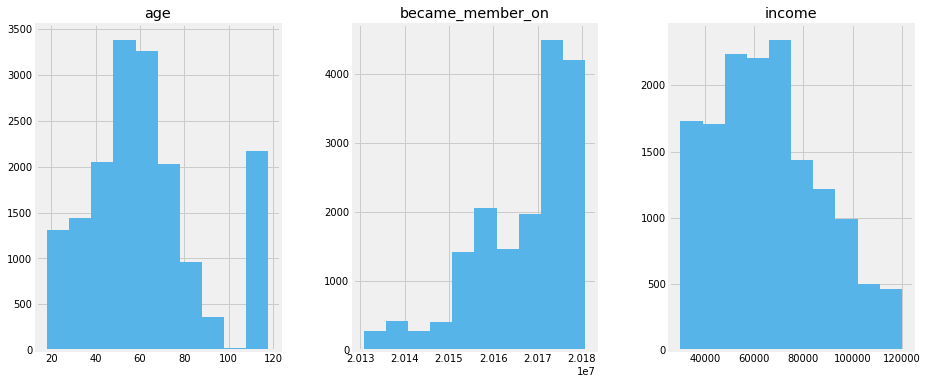

In [12]:
profile.hist(figsize=(14,6), layout=(1,3), color=sns.color_palette('colorblind')[-1], grid=True);
plt.savefig('./pic/profile_distribution.png', dpi=300, quality=80, bbox_inches='tight')

In [13]:
profile[profile['income']<40000].shape[0]/profile.shape[0]

0.11411764705882353

**Notes:**

- id: customor id, primary key
- customers who leave blank age and gender are all 118 years old.
- age might be classified into categories as (,30],(30,45],(45,60],(60,]
- became_member_on might be classified into (,2014],(2014,2015],(2015,2016],(2016,2017](2017,2018],(2018,]
- income might be classifed into 5 categories.

#### insghits

**From above, we can observe that there are 2175 observations with age 118 which is also the maximum age. The number of observations for this age is way too much than the number of observations for second highest age 101 which is only 5 which indicates that there are more people with age 118 than with age 101 which seems unrealistic. Also, the number of observations with age 118 i.e. 2175 is equal to the number of missing values in features gender and income. Let us analyse the profile data for age 118 more**.

### 1.2.2 Data Clean

- delet invalid records
- create proxies of customer rather than code

In [14]:
# slice
profile = profile[profile['income'].notnull()].reset_index(drop=True)

# create ordinary/categorical data
profile['age'] = pd.cut(x = profile['age'], 
                               bins = [profile['age'].min(), 30, 45, 60, 80,profile['age'].max()],
                               labels = ['<30','31~45','46~60','61~80','>80'])

profile['became_member_on'] = pd.cut(profile['became_member_on'], 
          bins=[profile['became_member_on'].min(), 20150000, 20160000,20170000, 20180000, profile['became_member_on'].max()], 
          labels = ['<2014','2014','2015','2017','2018'])

# convert id 
profile['id'] = profile['id'].map(id_dict)

In [15]:
    profile.head()

,age,became_member_on,gender,id,income
0,46~60,2017,F,C_2,112000.0
1,61~80,2017,F,C_4,100000.0
2,61~80,2018,M,C_6,70000.0
3,61~80,2018,M,C_9,53000.0
4,46~60,2017,M,C_13,51000.0


## 1.3. Table of transcript

### 1.3.1 Data Assess

In [16]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [17]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [18]:
transcript['event'].unique().tolist()

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [19]:
transcript['time'].max()

714

**Notes**

- the designed procedure should be:  
    - offer_received --> offer_veiwed --> transaction --> offer completed

- it's better to seprete the table of transcript into 4 tables refering to 4 events .

- value should be extracted from dictionary.

### 1.3.2 Data Clean

- extract values from dictionary 
- transfer code of person and offer types to short labels.
- seperate the table of transcript into 4 tables. They are offer_received, offer_viewed, offer_completed, and transcation.

In [20]:
# extract values from dictionary
transcript['value'] = transcript['value'].apply(lambda x: list(x.values())[0])

# map the columns of person and value from id_dict
transcript['person'] = transcript['person'].map(id_dict)
transcript.loc[transcript["event"] != 'transaction',"value"] = transcript.loc[transcript["event"] != 'transaction',"value"].map(id_dict)

In [21]:
# seperate the table of transcript into 4 tables. They are offer_received, offer_viewed, offer_completed, and transcation. 
# and rename the columns respectively. 
offer_received = transcript.query("event == 'offer received'").loc[:,['person','time','value']]
offer_received.columns = ['person','received_time','received_offer']

offer_viewed = transcript.query("event == 'offer viewed'").loc[:,['person','time','value']]
offer_viewed.columns = ['person','viewed_time','viewed_offer']

transaction = transcript.query("event == 'transaction'").loc[:, ['person','time','value']]
transaction.columns = ['person','purchase_time','amount']
transaction['amount'] = transaction['amount'].astype(float)

offer_completed = transcript.query("event == 'offer completed'").loc[:, ['person','time','value']]
offer_completed.columns =  ['person','completed_time','completed_offer']

## 1.4 Summary

In [22]:
q1 = transcript['person'].nunique()
q2 = offer_received['person'].nunique()
q3 = q1 - q2
q4 = offer_completed['person'].nunique()
q5 = len(set(offer_received['person']) - set(transaction['person']))
q6 = offer_viewed['person'].nunique()
q7 = len(set(set(offer_received['person']) - set(offer_viewed['person'])) - set(transaction['person']))

In [23]:
print("""
There are %d customers contained in the simulated data set. Only these person who received offers and completes the offers would be awarded. 
%d person received offers while %d person did not. Each person might receive several types of offer, %d person at least completed an offer and were rewarded. %d person received offers but did not have any consumption records. %d person did not view any offers they received. However, 
only %d person in them with no transaction records.\n
%d person who had not any transaction records are out of the range of this observation.
""" % (q1,q2,q3,q4,q5,q6,q7,q3))


There are 17000 customers contained in the simulated data set. Only these person who received offers and completes the offers would be awarded. 
16994 person received offers while 6 person did not. Each person might receive several types of offer, 12774 person at least completed an offer and were rewarded. 422 person received offers but did not have any consumption records. 16834 person did not view any offers they received. However, 
only 10 person in them with no transaction records.

6 person who had not any transaction records are out of the range of this observation.



# 2. To indentify customers who are responsive to coffee offers

## 2.1 Criteria for response record

- a customer who received the offer viewed the offer and completed the offer.
- a customer might received offers for several times, but the offers have to be viewed and complete in time.
- the offer type of informational is slightly different to the other offer types. There isn't a sign of completion so that we assume if any comsumption occurs after viewed during validity of date might be account for a qualified response record.

## 2.2 Create a response dataframe

### 2.2.1 seperate bogo, discount and informational

In [24]:
# offer_received_without_informational 
offer_bogo_discount = offer_received.query("not(received_offer == 'F_3' or received_offer == 'F_8')")
offer_informational = offer_received.query("received_offer == 'F_3' or received_offer == 'F_8'")

### 2.2.1 find response for bogo and discount offer

In [25]:
# prepare
response = offer_bogo_discount.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response = response.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response['isValid'] = ((response['viewed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['viewed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"duration"]

# connect viewed offers and completed offers
response = response.merge(offer_completed, left_on = ['person','received_offer'], right_on = ['person', 'completed_offer'])
response['isValid'] = ((response['completed_time'] - response['received_time']) <= response['duration']) & \
                                ((response['completed_time'] - response['received_time'] >= 0))
response = response.loc[response['isValid'], :"received_offer"]

In [26]:
response['person'].nunique()

1531

In [27]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


### 2.2.2 find responses for informational offer

In [28]:
# prepare
response_info = offer_informational.merge(portfolio[['id','duration']], left_on='received_offer', right_on = 'id')
response_info.drop('id', axis=1, inplace=True)

# connect received offers and viewed offers
response_info = response_info.merge(offer_viewed, left_on = ['person','received_offer'], right_on = ['person', 'viewed_offer'])
response_info['isValid'] = ((response_info['viewed_time'] - response_info['received_time']) <= response_info['duration']) & \
                                ((response_info['viewed_time'] - response_info['received_time'] >= 0))
response_info = response_info.loc[response_info['isValid'], :"duration"]

# connect viewed offers and transaction records
response_info = response_info.merge(transaction, on="person")

def isValid_info(response_info): # valid metric 
    if (response_info['purchase_time'] >= response_info['received_time']) & \
       (response_info['purchase_time'] <= (response_info['received_time'] + response_info['duration'])): 
        return True
    else:
        return False
response_info['isValid'] = response_info.apply(isValid_info, axis=1)

response_info = response_info[response_info['isValid']].groupby(['person','received_time','received_offer'])['amount'].sum().reset_index().loc[:,:'received_offer']

### 2.2.3 all response records

In [29]:
# merge 
response = pd.concat([response,response_info])

In [30]:
response.head()

,person,received_time,received_offer
2,C_175,0,F_4
17,C_982,168,F_4
28,C_2283,0,F_4
35,C_2611,0,F_4
41,C_2894,0,F_4


## 2.3 Q1: What's the response rate?

### 2.3.1 Overall

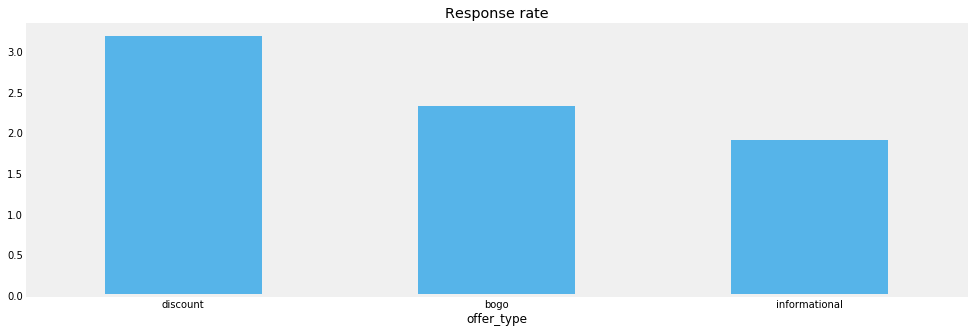

In [31]:
# number of response
stat_response = response.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_response.drop('id', axis=1, inplace=True)

# number of all received offer
stat_all = offer_received.merge(portfolio[['id','offer_type','difficulty','duration','reward']], left_on='received_offer', right_on='id')
stat_all.drop('id', axis=1, inplace=True)

# response rate
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100).rename("response_rate").\
sort_values(ascending = False).plot.bar(figsize=(15,5), rot=0, title="Response rate",color=sns.color_palette('colorblind')[-1], grid=False);
plt.savefig('./pic/response_rate_overall.png', dpi=300, bbox_inches='tight')

In [32]:
((stat_response.groupby('offer_type').size()/stat_all.groupby('offer_type').size())*100)

offer_type
bogo             2.324666
discount         3.185673
informational    1.910075
dtype: float64

### 2.3.2 subset

In [33]:
response_rate = (stat_response.groupby(['offer_type','difficulty','duration','reward']).size()/stat_all.groupby(['offer_type','difficulty','duration','reward']).size()*100).round(2)

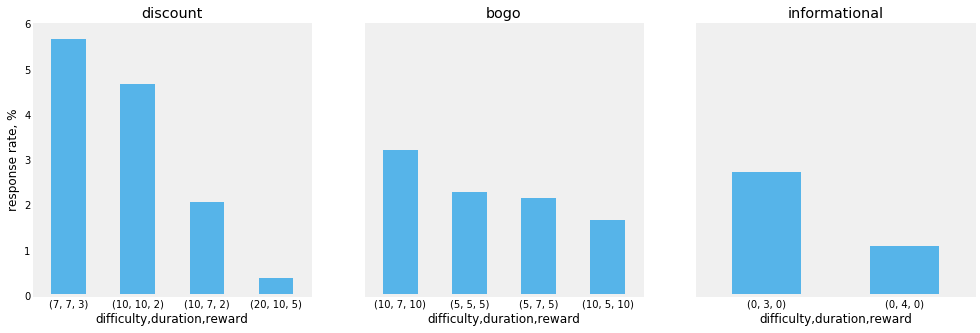

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

idx = pd.IndexSlice
ax1 = response_rate.loc[idx['discount']].sort_values(ascending = False).plot.bar(title='discount', color=sns.color_palette('colorblind')[-1], ax=ax1, rot=0,ylim=(0,6), grid=False)
ax1.set_ylabel("response rate, %")
ax2 = response_rate.loc[idx['bogo']].sort_values(ascending = False).plot.bar(title='bogo', color=sns.color_palette('colorblind')[-1], ax=ax2, rot=0, sharey=True,ylim=(0,6),grid=False)
ax3 = response_rate.loc[idx['informational']].sort_values(ascending = False).plot.bar(title='informational', color=sns.color_palette('colorblind')[-1], ax=ax3,rot=0,sharey=True,ylim=(0,6),grid=False)

plt.savefig('./pic/response_rate_subset.png', bbox_inches='tight', dpi=300)

## 2.4 Which groups of people are most responsive to each type of offer?

In [35]:
response_person = response.drop_duplicates(subset=['person'])
response_person = response_person.merge(profile, left_on='person', right_on = 'id')
response_person.drop('id', axis=1, inplace=True)
response_person = response_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
response_person.drop('id', axis=1, inplace=True)

# convert data of income in profile as category data
response_person['income'] = pd.cut(response_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [36]:
response_person.head()

,person,received_time,received_offer,age,became_member_on,gender,income,offer_type
0,C_175,0,F_4,46~60,2018,M,60k~80k,bogo
1,C_982,168,F_4,46~60,2017,O,60k~80k,bogo
2,C_2283,0,F_4,46~60,2017,F,60k~80k,bogo
3,C_2611,0,F_4,31~45,2014,M,80k~100k,bogo
4,C_2894,0,F_4,46~60,2017,M,40k~60k,bogo


In [37]:
all_person = offer_received.drop_duplicates('person')
all_person = all_person.merge(profile, left_on='person', right_on='id')
all_person.drop('id', axis=1, inplace=True)
all_person = all_person.merge(portfolio[['id','offer_type']], left_on='received_offer', right_on='id')
all_person.drop('id', axis=1, inplace=True)

# convert data of income as category data
all_person['income'] = pd.cut(all_person['income'], 
          bins=[profile['income'].min(), 40000, 60000, 80000,100000, profile['income'].max()], 
          labels = ['<40k', '40k~60k', '60k~80k', '80k~100k', '>100k'])

In [38]:
all_person.head()

,person,received_time,received_offer,age,became_member_on,gender,income,offer_type
0,C_4,0,F_4,61~80,2017,F,80k~100k,bogo
1,C_30,0,F_4,46~60,2014,M,40k~60k,bogo
2,C_35,0,F_4,31~45,2015,M,<40k,bogo
3,C_43,0,F_4,31~45,2018,M,<40k,bogo
4,C_48,0,F_4,46~60,2017,F,60k~80k,bogo


In [39]:
def profile_plot(key, rot):
    """
    plot demographic difference on key variable bewteen response_person and all_person.  
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    overall = all_person.groupby(['offer_type',key])['person'].count().groupby(level=0).apply(lambda x: x/x.sum() * 100).round(2)
    
    profile_invest = pd.DataFrame(underlying.rename('Response')).join(overall.rename('Overall'))
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit))
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit))
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit));
    
    file_name = './pic/demograhic_differ_on_' + key + '.png'
    plt.savefig(file_name, bbox_inches='tight', dpi=300)
    
    plt.show()
    

In [40]:
def profile_plot_1(key, rot=0, color=sns.color_palette('colorblind')[-1]):
    """
    plot response rate on key demographic variable for response_person. 
    
    """
    
    underlying = response_person.groupby(['offer_type', key])['person'].count()
    overall = all_person.groupby(['offer_type',key])['person'].count()
    
    profile_invest = ((underlying/overall)*100).rename("response_rate")
    
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    idx = pd.IndexSlice
    
    y_limit = round(profile_invest.max().max())+1
    profile_invest .loc[idx['discount']].plot.bar(title="discount",ax=ax1, rot=rot, ylim=(0,y_limit), legend=False, color=color,grid=False)
    ax1.set_ylabel("response rate, %")
    profile_invest .loc[idx['bogo']].plot.bar(title="bogo",ax=ax2, rot=rot,legend=False,ylim=(0, y_limit),color=color, grid=False)
    profile_invest .loc[idx['informational']].plot.bar(title="informational",ax=ax3,rot=rot, legend=False,ylim=(0,y_limit),color=color, grid=False);
    
    file_name = './pic/response_rate_on_' + key + '.png'
    plt.savefig(file_name, bbox_inches='tight', dpi=300)
    
    plt.show()
  

### 2.4.1 age

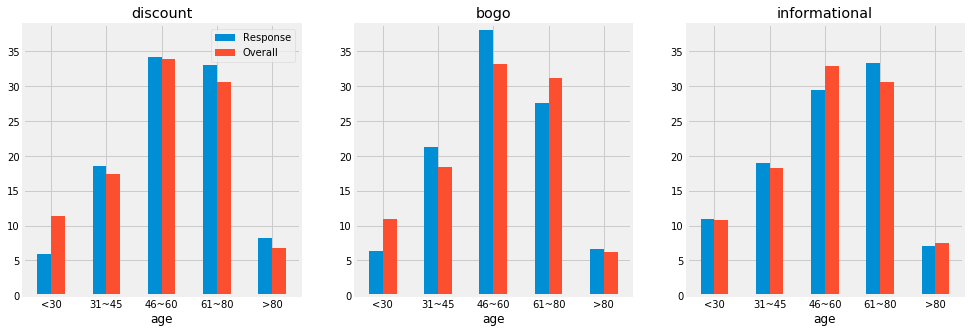

In [41]:
profile_plot('age', 0)

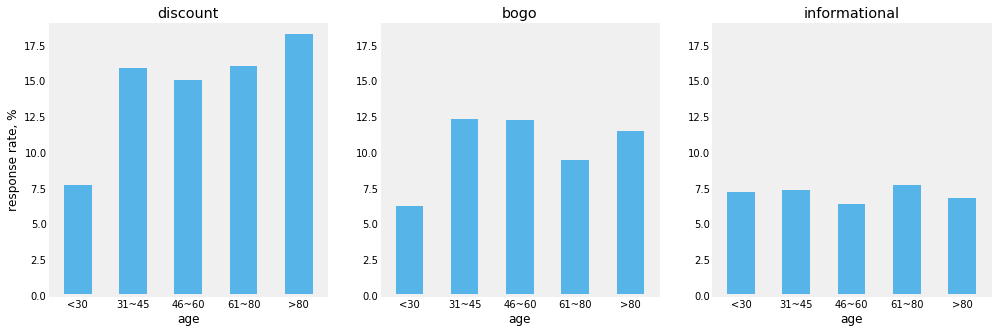

In [42]:
profile_plot_1('age',0)

### 2.4.2 became member on

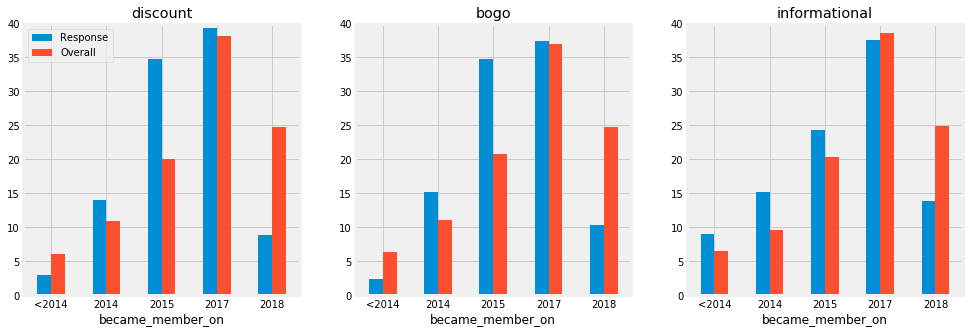

In [43]:
profile_plot('became_member_on',0)

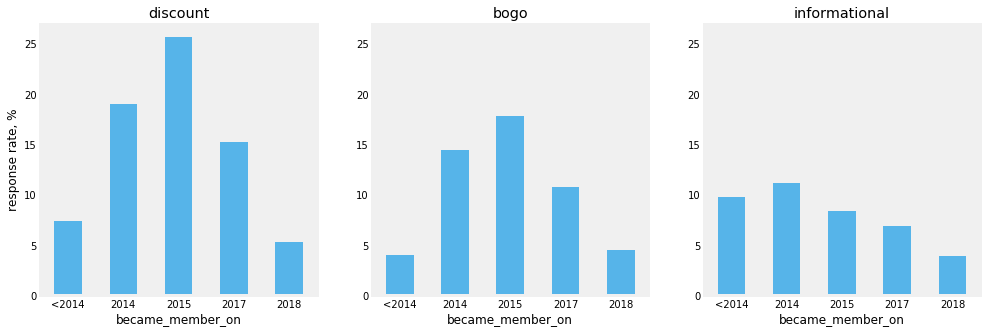

In [44]:
profile_plot_1('became_member_on',0)

### 2.4.3 income

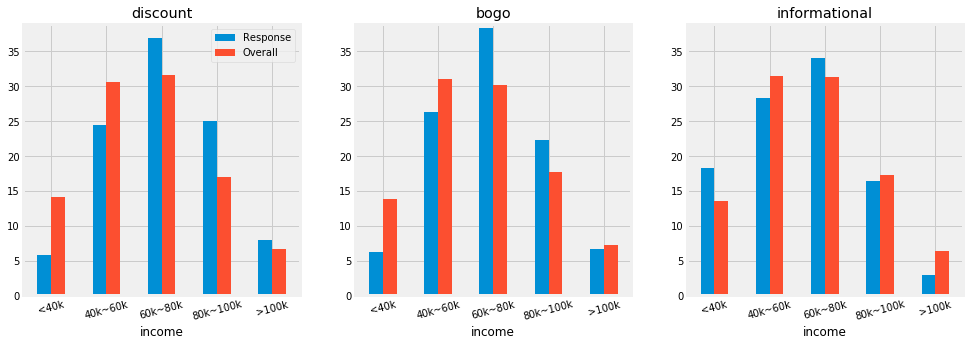

In [45]:
profile_plot('income', 15)

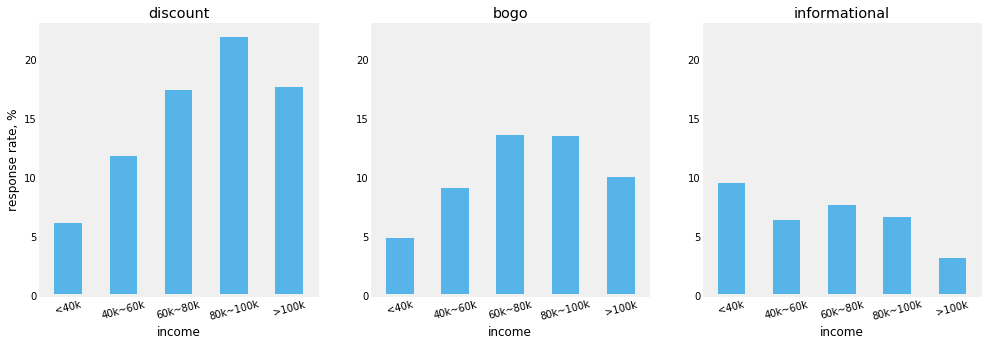

In [46]:
profile_plot_1('income', 15)

# 3. How much someone will spend based on demographics and offer types?

## 3.1 Data Preparation 

- endogenous variable: average amount of purchases
- exogenous variable: including factors of the profiles and offer types and we should know if the customer is responsive to what types of offers. 

### 3.1.1 data set

In [79]:
# merge proflle and response in order to know who is responsive to coffee offers
df = profile.merge(response[['person','received_offer']], left_on='id', right_on='person', how='left')
df.drop('person', axis=1, inplace=True)

# join average transaction data to proflie  
df = df.set_index('id').join(transaction.groupby('person')['amount'].sum(), how="inner")

# drop those customers who didn't receive any coffee offers
exclude_ind = np.array(list(set(transaction['person'])-set(offer_received['person'])))
df = df.iloc[np.where(np.logical_not(np.isin(df.index.values, exclude_ind)))[0]]

AttributeError: module 'numpy' has no attribute 'isin'

**3.1.2 outliers**

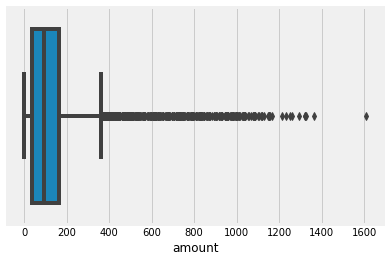

In [48]:
sns.boxplot(x='amount',data=df);

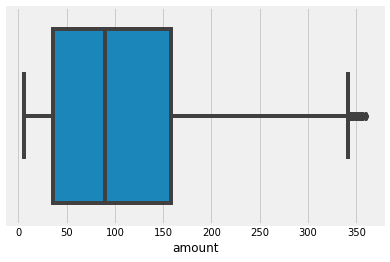

In [49]:
# identify outliers
IQR = df['amount'].quantile(0.75) - df['amount'].quantile(0.25)
outlier = df['amount'].quantile(0.75) + 1.5 * IQR 

# eliminate outliers
df = df[(df['amount'] < outlier) & (df['amount'] > 6) ]
sns.boxplot(x='amount',data=df);

***3.1.3 transformation***

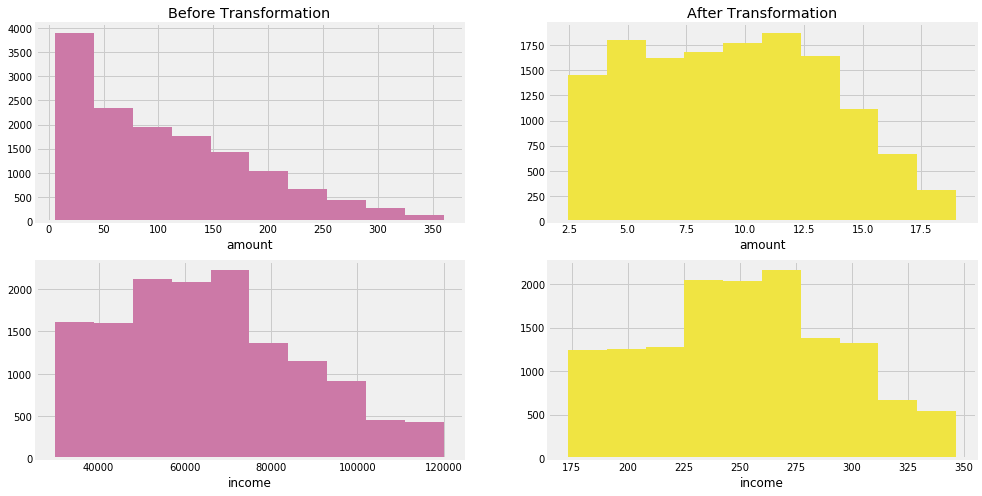

In [50]:
# distribution of amount
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(15,8))
ax1=df['amount'].hist(ax=ax1, color=sns.color_palette('colorblind')[-3])
ax1.set_title('Before Transformation')
ax1.set_xlabel('amount')

ax2=np.sqrt(df['amount']).hist(ax=ax2, color=sns.color_palette('colorblind')[-2])
ax2.set_title('After Transformation')
ax2.set_xlabel('amount')

ax3=df['income'].hist(ax=ax3,color=sns.color_palette('colorblind')[-3])
ax3.set_xlabel('income')

ax4=np.sqrt(df['income']).hist(ax=ax4,color=sns.color_palette('colorblind')[-2])
ax4.set_xlabel('income')

plt.savefig('./pic/reg_distribution.png', bbox_inches='tight', dpi=300)

In [51]:
# data transform
df['amount'] = np.sqrt(df['amount'])
df['income'] = np.sqrt(df['income'])

***3.1.4 transfer categories to dummy variable, and normalize***

In [52]:
# dummy variables
df = pd.get_dummies(df)

# drop 'gender_M', 'gender_O'  , because they aren't indipendent with gender_F
df.drop(['gender_M', 'gender_O'], axis=1, inplace=True)

In [53]:
# normalize scalar
scalar = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(df)
scaled_df = scalar.transform(df)


***3.1.4 split train and test***

In [54]:
y = scaled_df[:,1]
X = np.delete(scaled_df,1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

### 4.1 Modeling

### 4.1.1a Linear regression model fitting

In [55]:
# model fit
reg = sm.OLS(y_train,X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     2734.
Date:                Sun, 23 May 2021   Prob (F-statistic):               0.00
Time:                        09:46:11   Log-Likelihood:                 2586.2
No. Observations:               10453   AIC:                            -5128.
Df Residuals:                   10431   BIC:                            -4969.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3332      0.008     40.083      0.000       0.317       0.349
x2             0.0115      0.026      0.446      0.656      -0.039       0.062
x3             0.0350      0.026      1.363      0.173      -0.015       0.085
x4             0.0326      0.026      1.275      0.202      -0.018       0.083
x5             0.0347      0.026      1.359      0.174      -0.015       0.085
x6             0.0235      0.026      0.889      0.374      -0.028       0.075
x7             0.1849      0.026      7.034      0.000       0.133       0.236
x8             0.2780      0.026     10.748      0.000       0.227       0.329
x9             0.3109      0.026     12.064      0.000       0.260       0.361
x10            0.1934      0.026      7.569      0.000       0.143       0.243
x11            0.0760      0.026      2.975      0.003       0.026       0.126
x12            0.0509      0.004     13.061      0.000       0.043       0.058
x13            0.2161      0.015     14.751      0.000       0.187       0.245
x14            0.1882      0.018     10.536      0.000       0.153       0.223
x15            0.1931      0.020      9.716      0.000       0.154       0.232
x16            0.1847      0.028      6.527      0.000       0.129       0.240
x17            0.1685      0.019      8.964      0.000       0.132       0.205
x18            0.1614      0.043      3.713      0.000       0.076       0.247
x19            0.1771      0.011     15.872      0.000       0.155       0.199
x20            0.2029      0.013     16.050      0.000       0.178       0.228
x21            0.1028      0.016      6.237      0.000       0.070       0.135
x22            0.1774      0.017     10.475      0.000       0.144       0.211
==============================================================================
Omnibus:                      211.251   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.891
Skew:                           0.335   Prob(JB):                     1.32e-47
Kurtosis:                       2.782   Cond. No.                         43.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.1.1b Multi factor regression model

In [56]:
reg = LinearRegression().fit(X_train, y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))))

 R2 for train set: 0.40, 
 R2 for test set: 0.41


### 4.2.1 Random Forest model

In [57]:
regr = RandomForestRegressor(max_depth=7)
regr.fit(X_train,y_train)
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))))

 R2 for train set: 0.41, 
 R2 for test set: 0.37


### 4.2.2 Supported vector regression

In [58]:
svr = SVR()
svr.fit(X_train, y_train) 
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))))

 R2 for train set: 0.42, 
 R2 for test set: 0.42


### 4.2.3 Results

In [59]:
model_dict={"Linear Regression": [r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))],
                  "Random Forest Regression":  [r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))],
                  "Supported Vector Rregreesion":  [r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))],
           }
pd.DataFrame(model_dict, index=['R2_train', 'R2_test']).round(2)

,Linear Regression,Random Forest Regression,Supported Vector Rregreesion
R2_train,0.40,0.41,0.42
R2_test,0.41,0.37,0.42


## 4.3 Improvement 

In [60]:
# merge proflle and response in order to know who is responsive to coffee offers
df = profile.merge(response[['person','received_offer']], left_on='id', right_on='person', how='left')
df.drop('person', axis=1, inplace=True)

# join average transaction data to proflie  
df = df.set_index('id').join(transaction.groupby('person')['amount'].sum(), how="inner")

# drop those customers who didn't receive any coffee offers
exclude_ind = np.array(list(set(transaction['person'])-set(offer_received['person'])))
df = df.iloc[np.where(np.logical_not(np.isin(df.index.values, exclude_ind)))[0]]

AttributeError: module 'numpy' has no attribute 'isin'

### **5. transfer categories to dummy variable, and normalize**

In [61]:
# dummy variables
df = pd.get_dummies(df)

# drop 'gender_M', 'gender_O'  , because they aren't indipendent with gender_F
df.drop(['gender_M', 'gender_O'], axis=1, inplace=True)

In [62]:
# normalize scalar
scalar = MinMaxScaler(copy=True, feature_range=(0, 1)).fit(df)
scaled_df = scalar.transform(df)

### 5.1.1 split train and test

In [63]:
y = scaled_df[:,1]
X = np.delete(scaled_df,1,1)
X_train, X_test, y_train, y_test = train_test_split(X,y)

## 5.1.2 modeling

### 5.1.2.1 Linear regression model

In [64]:
# model fit
reg = sm.OLS(y_train,X_train).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     666.7
Date:                Sun, 23 May 2021   Prob (F-statistic):               0.00
Time:                        09:50:12   Log-Likelihood:                 13237.
No. Observations:               11016   AIC:                        -2.643e+04
Df Residuals:                   10994   BIC:                        -2.627e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0890      0.003     28.134      0.000       0.083       0.095
x2             0.0035      0.010      0.337      0.736      -0.017       0.024
x3             0.0069      0.010      0.669      0.503      -0.013       0.027
x4             0.0029      0.010      0.278      0.781      -0.017       0.023
x5             0.0032      0.010      0.309      0.757      -0.017       0.023
x6             0.0048      0.011      0.456      0.649      -0.016       0.026
x7             0.0137      0.011      1.300      0.193      -0.007       0.034
x8             0.0461      0.010      4.430      0.000       0.026       0.066
x9             0.0495      0.010      4.781      0.000       0.029       0.070
x10            0.0266      0.010      2.590      0.010       0.006       0.047
x11            0.0008      0.010      0.081      0.936      -0.019       0.021
x12            0.0102      0.001      7.002      0.000       0.007       0.013
x13            0.0538      0.006      9.741      0.000       0.043       0.065
x14            0.0475      0.007      6.759      0.000       0.034       0.061
x15            0.0368      0.008      4.757      0.000       0.022       0.052
x16            0.0388      0.010      3.865      0.000       0.019       0.058
x17            0.0543      0.007      8.189      0.000       0.041       0.067
x18            0.0340      0.016      2.084      0.037       0.002       0.066
x19            0.0434      0.004     10.324      0.000       0.035       0.052
x20            0.0541      0.005     11.726      0.000       0.045       0.063
x21            0.0285      0.006      4.687      0.000       0.017       0.040
x22            0.0358      0.007      5.467      0.000       0.023       0.049
==============================================================================
Omnibus:                     9628.701   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           329544.155
Skew:                           4.165   Prob(JB):                         0.00
Kurtosis:                      28.467   Cond. No.                         45.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
print((" R2 for train set: %.2f, \n R2 for test set: %.2f")  % (r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))))

 R2 for train set: 0.21, 
 R2 for test set: 0.23


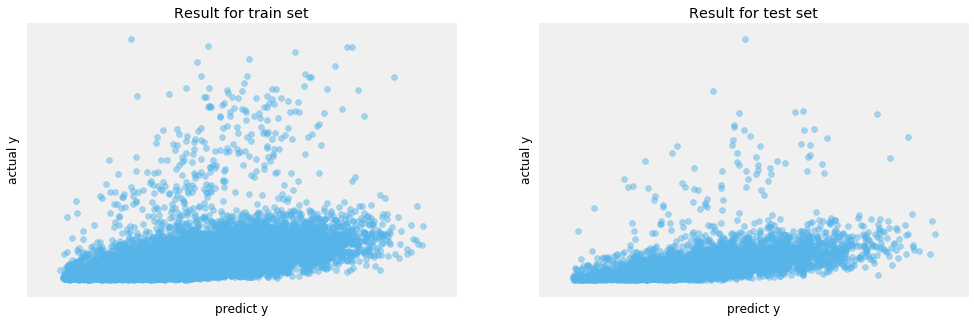

In [66]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(15,5))
ax1.scatter(x=reg.predict(X_train), y=y_train,alpha=0.5,color=sns.color_palette('colorblind')[-1])
ax1.set_title("Result for train set")
ax1.set_xlabel('predict y')
ax1.set_ylabel('actual y')
ax1.set_xticklabels('')
ax1.set_yticklabels('')
ax1.grid(False)

ax2.scatter(x=reg.predict(X_test), y=y_test, alpha=0.5,color=sns.color_palette('colorblind')[-1])
ax2.set_title("Result for test set")
ax2.set_xlabel('predict y')
ax2.set_ylabel('actual y')
ax2.set_xticklabels('')
ax2.set_yticklabels('')
ax2.grid(False)
plt.savefig("./pic/reg_result.png", bbox_inches='tight',dpi=300)

In [67]:
betas = pd.DataFrame(reg.params, index=(np.delete(df.columns.values,1)), columns=['params'])
betas['t_value'] = reg.tvalues

In [68]:
betas

,params,t_value
income,0.088973,28.133603
age_<30,0.003512,0.337281
age_31~45,0.006919,0.669116
age_46~60,0.002862,0.277919
age_61~80,0.003185,0.309149
age_>80,0.004823,0.455548
became_member_on_<2014,0.013681,1.300408
became_member_on_2014,0.046075,4.429949
became_member_on_2015,0.049498,4.781385
became_member_on_2017,0.026643,2.590415


In [69]:
def split_betas(key):
    """
    split index of table of beta to variable name and value.
    for example, received_offer_F_9 should be split to received_offer and F_9.
    return series according key.
    """
    factor = betas.loc[[key.split("_")[0] in ind.split('_') for ind in betas.index]]['params']
    factor.index = factor.index.str.split("_").str[-1]
    return factor.rename(key)

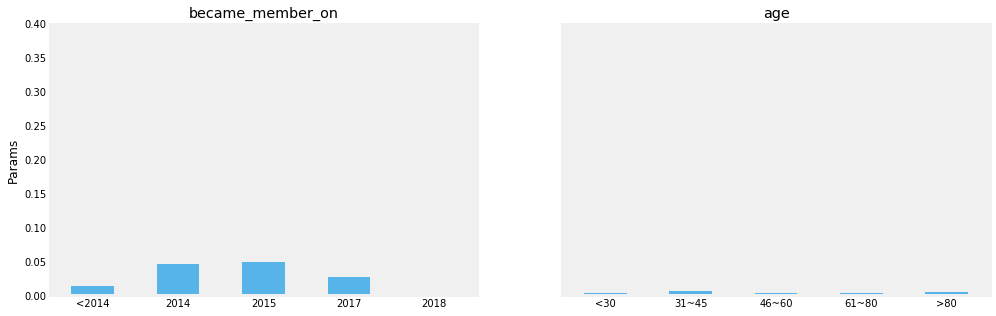

In [70]:
# age, become_member_on, gender ploting
betas_age =  split_betas('age')
betas_become_member = split_betas('became_member_on')
betas_gender = split_betas('gender')

fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
ax2 = betas_age.plot.bar(title='age',ax=ax2, rot=0, legend=False,  ylim=(0.,0.4), sharey=True,color=sns.color_palette('colorblind')[-1])
ax2.set_ylabel('Param weights')
ax2.grid(False)
ax1 = betas_become_member.plot.bar(title = 'became_member_on',ax=ax1, rot=0, legend=False, ylim=(0.,0.4),color=sns.color_palette('colorblind')[-1])
ax1.grid(False)
ax1.set_ylabel("Params")
plt.savefig('./pic/reg_result_demogriphic.png', bbox_inches='tight', dpi=300)

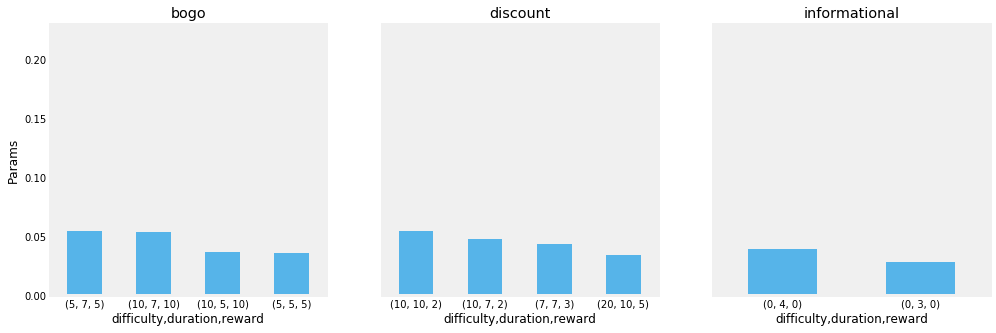

In [71]:
# offer type ploting
betas_offer = split_betas('offer')
betas_offer.index =  betas_offer.index.astype(int) - 1
betas_offer = pd.DataFrame(betas_offer).join(portfolio[['offer_type', 'difficulty','duration','reward']])
betas_offer = betas_offer.groupby(['offer_type', 'difficulty','duration','reward'])['offer'].sum()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,5))

idx = pd.IndexSlice
ax2 = betas_offer.loc[idx['discount']].sort_values(ascending = False).plot.bar(title='discount', color=sns.color_palette('colorblind')[-1], ax=ax2, rot=0, ylim=(0.,0.23), sharey=True)
ax2.grid(False)

ax1 = betas_offer.loc[idx['bogo']].sort_values(ascending = False).plot.bar(title='bogo', color=sns.color_palette('colorblind')[-1], ax=ax1, rot=0, ylim=(0.,0.23))
ax1.set_ylabel("Params")
ax1.grid(False)

ax3 = betas_offer.loc[idx['informational']].sort_values(ascending = False).plot.bar(title='informational', color=sns.color_palette('colorblind')[-1], ax=ax3,rot=0,ylim=(0.,0.23), sharey=True)
ax3.grid(False)

plt.savefig('./pic/reg_result_response.png', bbox_inches='tight', dpi=300)

### 5.1.2.2 Random Forest model

In [72]:
regr = RandomForestRegressor(max_depth=7)
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [73]:
    print(' train score: %.4f \n test score:  %.4f ' %(regr.score(X_train, y_train),regr.score(X_test, y_test)))

 train score: 0.2587 
 test score:  0.1984 


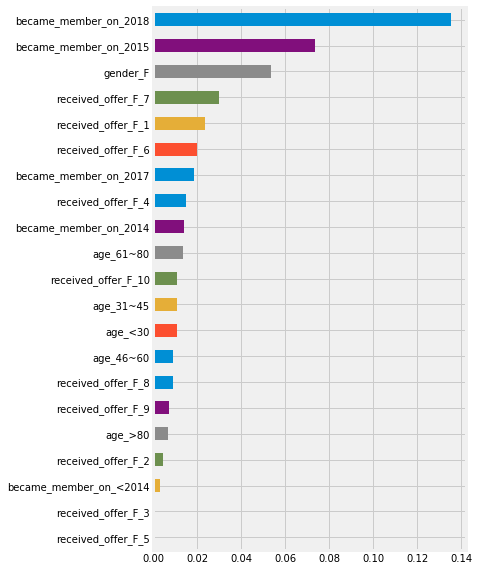

In [74]:
feature_importance =  pd.Series(regr.feature_importances_, index=(np.delete(df.columns.values,1))).astype(float)
feature_importance[1:].sort_values().plot.barh(figsize=(5,10))

### 5.1.2.3 SVR

In [75]:
svr = SVR()
svr.fit(X_train, y_train) 

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
svr.score(X_train, y_train), svr.score(X_test, y_test)

(-0.098923871341272784, -0.11649507108982472)

In [77]:
model_dict={"Linear Regression": [r2_score(y_train,reg.predict(X_train)), r2_score(y_test,reg.predict(X_test))],
                  "Random Forest Regression":  [r2_score(y_train,regr.predict(X_train)), r2_score(y_test,regr.predict(X_test))],
                  "Supported Vector Rregreesion":  [r2_score(y_train,svr.predict(X_train)), r2_score(y_test,svr.predict(X_test))],
           }

In [78]:
pd.DataFrame(model_dict, index=['R2_train', 'R2_test']).round(2)

,Linear Regression,Random Forest Regression,Supported Vector Rregreesion
R2_train,0.21,0.26,-0.10
R2_test,0.23,0.20,-0.12


### 6 Reflection

**The most interesting aspect of this project which I really liked was how different set of data i.e. offer data, customer demographic data and transcript data were combined to gain insights using predictive modeling techniques and analysis to provide better business decisions and value to the business. The toughest part of this entire analysis was finding logic and strategy to make combined dataset based on the duration of the offer when it was active for customers.**

### 7 Improvement

**1.**	*`“Coming up with features is difficult, time-consuming, requires expert knowledge. ‘Applied machine learning’ is basically feature engineering.” - Prof. Andrew Ng`*. **Therefore, more feature engineering could be performed on offer, customer demographic and transaction data in order to have more better model.**

**2.	Also, we can improve this project by taking up another problem statement i.e. determining how much a customer could spend based upon the offer data and demographic data using the supervised machine learning regression algorithms which inturn would help in finding out if the customer would respond or not as ‘total amount’ which a customer could spend is the top most feature in the best trained classifier model.**

**3.	Also, we can improve the project by making our nearly balanced (slightly imbalanced) dataset into a perfectly balanced dataset using [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). This would further improve the performance of classification model.**

**4.	We can also perform the clustering modeling (behavioral clustering, product-based clustering, brand-based clustering) for customer segmentation into groups based on several variables at once. With it, we can target specific demographics and personas for different targets.**